### 0) Ustawienia + ścieżki + wersje

In [1]:
# --- USTAWIENIA ---
from pathlib import Path
import os, sys, platform

# katalogi
IMG_DIR = Path("/Users/olga/MetaLogic/inputs")      # <- dostosuj w razie potrzeby
OUT_DIR = Path("/Users/olga/MetaLogic/outputs/ocr")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# kredencjały Vision (lokalnie na Macu)
KEY = Path.home() / "MetaLogic" / "secrets" / "vision-key.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(KEY)

# diagnostyka
print("PY:", sys.executable, "|", platform.python_version())
print("IMG_DIR:", IMG_DIR.resolve())
print("OUT_DIR:", OUT_DIR.resolve())
print("GOOGLE_APPLICATION_CREDENTIALS exists:", KEY.exists(), "→", KEY)

PY: /Users/olga/MetaLogic/.venv/bin/python | 3.13.7
IMG_DIR: /Users/olga/MetaLogic/inputs
OUT_DIR: /Users/olga/MetaLogic/outputs/ocr
GOOGLE_APPLICATION_CREDENTIALS exists: True → /Users/olga/MetaLogic/secrets/vision-key.json


### 1) Diagnoza środowiska i wersji

In [2]:
mods = [
    ("numpy", "np"),
    ("cv2", "cv2"),
    ("PIL", "PIL"),
    ("google.cloud.vision", "vision"),
    ("ipywidgets", "ipyw"),
]
for mod, _alias in mods:
    try:
        m = __import__(mod)
        ver = getattr(m, "__version__", "n/a")
        print(f"[OK] {mod} {ver}")
    except Exception as e:
        print(f"[FAIL] {mod} -> {e}")

# dodatkowo: wersja OpenCV (jeśli jest)
try:
    import cv2
    print("OpenCV build info:", cv2.__version__)
except Exception:
    pass

[OK] numpy 2.2.6
[OK] cv2 4.12.0
[OK] PIL 12.0.0
[OK] google.cloud.vision n/a
[OK] ipywidgets 8.1.8
OpenCV build info: 4.12.0


### 1a) ipywidgets / klient Vision

In [3]:
from google.cloud import vision

# sanity check ipywidgets
try:
    import ipywidgets as W
    print("ipywidgets:", W.__version__)
except Exception as e:
    print("ipywidgets FAIL ->", e)

# klient Vision (powstaje dopiero po ustawieniu GOOGLE_APPLICATION_CREDENTIALS w #0)
try:
    vision_client = vision.ImageAnnotatorClient()
    print("Vision client OK")
except Exception as e:
    print("Vision client FAIL ->", e)

ipywidgets: 8.1.8
Vision client OK


### 2) Wybór jednego obrazu

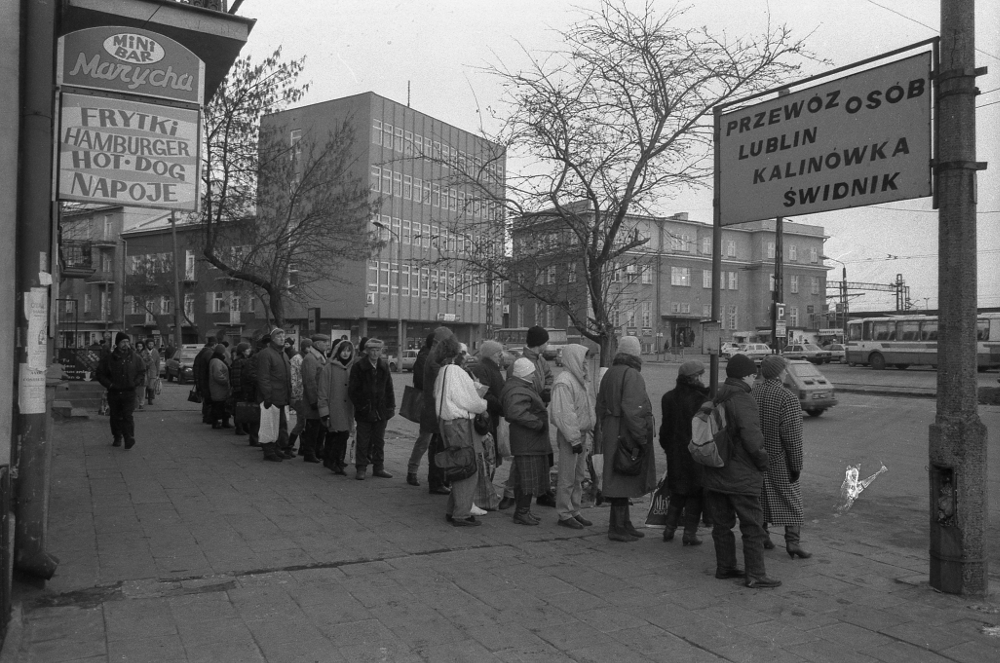

In [ ]:
# (2) Wybór jednego obrazu z katalogu IMG_DIR
from pathlib import Path
from ipywidgets import Dropdown, Button, HBox, VBox, HTML
from IPython.display import display
from PIL import Image

DIR = IMG_DIR
EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".webp"}

def list_images():
    return sorted([p for p in DIR.iterdir() if p.is_file() and p.suffix.lower() in EXTS])

files = list_images()
status = HTML(value=f"Katalog: {DIR} • {len(files)} plików")
dd = Dropdown(options=[(p.name, str(p)) for p in files], description="Obraz:", layout={"width":"600px"})
btn_refresh = Button(description="Odśwież")
btn_use = Button(description="Użyj", disabled=(len(files)==0))

IMG_PATH = None  # globalnie

def on_refresh(_):
    files[:] = list_images()
    dd.options = [(p.name, str(p)) for p in files]
    btn_use.disabled = (len(files)==0)
    status.value = f"Katalog: {DIR} • {len(files)} plików"

def on_use(_):
    global IMG_PATH
    if not dd.value:
        status.value = "Brak wyboru."
        return
    IMG_PATH = Path(dd.value)
    status.value = f"✅ Wybrano: {IMG_PATH}"
    display(Image.open(IMG_PATH))

btn_refresh.on_click(on_refresh)
btn_use.on_click(on_use)

display(VBox([HBox([dd, btn_refresh, btn_use]), status]))

### 3 Pełny kadr

TEXT_DETECTION: 12 linii w 1.00s
Zapisano: /Users/olga/MetaLogic/outputs/ocr/0077_full.json

🔎 12 fragmentów tekstu:
- MINI
- Marycha
- FRYTKI
- HAMBURGER
- HOT
- DOG
- NAPOJE
- PRZEWOZ
- OSOB
- LUBLIN
- KALINÓWKA
- ŚWIDNIK


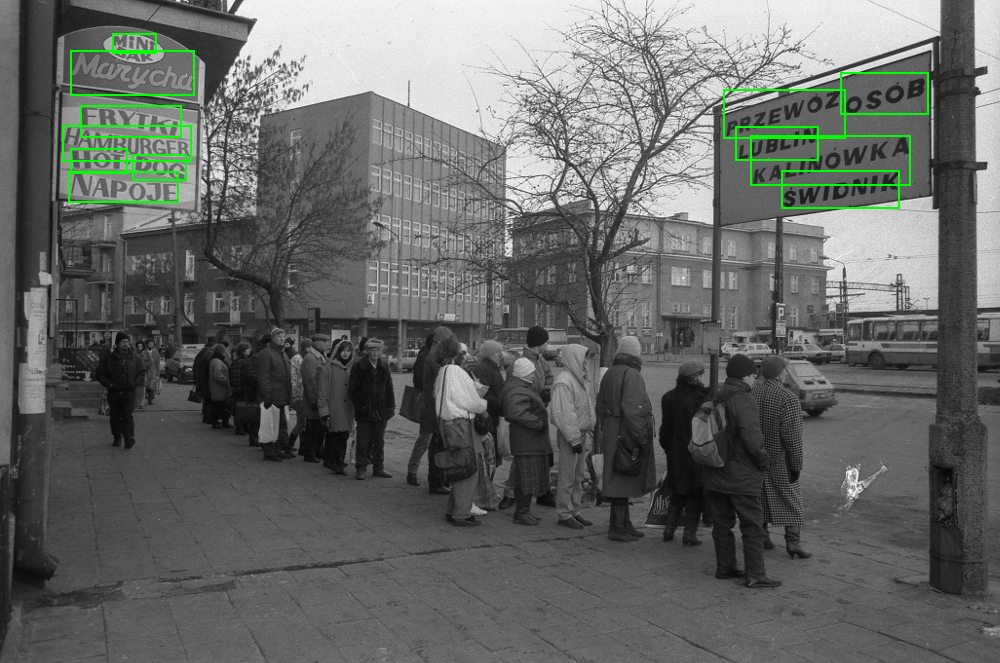

In [5]:
# 3 --- Pełny kadr (szybka wersja + podgląd wyników) ---
from google.cloud import vision
from PIL import Image, ImageEnhance, ImageDraw
from io import BytesIO
from time import perf_counter
import json

client = vision.ImageAnnotatorClient()

def _prep_for_ocr(img: Image.Image, max_side=1600, contrast=1.3, jpg_quality=85) -> bytes:
    # skala + delikatny kontrast
    w, h = img.size
    scale = min(1.0, max_side / max(w, h))
    if scale < 1.0:
        img = img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
    img = ImageEnhance.Contrast(img.convert("L")).enhance(contrast).convert("RGB")
    buf = BytesIO()
    img.save(buf, format="JPEG", quality=jpg_quality, optimize=True)
    return buf.getvalue()

def vision_ocr_full(img: Image.Image, lang=("pl","en"), mode="text", timeout=30):
    """
    mode: 'text' -> TEXT_DETECTION (szybciej), 'doc' -> DOCUMENT_TEXT_DETECTION (dokładniej)
    """
    content = _prep_for_ocr(img, max_side=1600, contrast=1.3, jpg_quality=85)
    image = vision.Image(content=content)
    ctx = vision.ImageContext(language_hints=list(lang))
    t0 = perf_counter()
    if mode == "doc":
        resp = client.document_text_detection(image=image, image_context=ctx, timeout=timeout)
        lines = []
        for page in resp.full_text_annotation.pages:
            for block in page.blocks:
                for para in block.paragraphs:
                    txt = "".join(sym.text for w in para.words for sym in w.symbols).strip()
                    box = para.bounding_box.vertices
                    xs, ys = [v.x for v in box], [v.y for v in box]
                    lines.append({"text": txt, "bbox":[min(xs),min(ys),max(xs),max(ys)], "src":"doc"})
    else:
        feat = [vision.Feature(type_=vision.Feature.Type.TEXT_DETECTION)]
        req = vision.AnnotateImageRequest(image=image, features=feat, image_context=ctx)
        resp = client.annotate_image(request=req, timeout=timeout)
        lines = []
        if resp.text_annotations:
            # element [0] to pełny zlepek; kolejne to „słowa” z bbox
            for ent in resp.text_annotations[1:]:
                v = ent.bounding_poly.vertices
                xs, ys = [p.x for p in v], [p.y for p in v]
                lines.append({"text": ent.description, "bbox":[min(xs),min(ys),max(xs),max(ys)], "src":"text"})
    dt = perf_counter() - t0
    return lines, dt


# === URUCHOMIENIE ===
img_full = Image.open(IMG_PATH)
text_lines, t_text = vision_ocr_full(img_full, mode="text")
print(f"TEXT_DETECTION: {len(text_lines)} linii w {t_text:.2f}s")

# jeśli mało wyników, spróbuj dokładniejszego trybu dokumentowego
if len(text_lines) < 8:
    doc_lines, t_doc = vision_ocr_full(img_full, mode="doc")
    print(f"DOCUMENT_TEXT_DETECTION: {len(doc_lines)} linii w {t_doc:.2f}s")
    lines = doc_lines
else:
    lines = text_lines

# zapis JSON
outf = OUT_DIR / f"{IMG_PATH.stem}_full.json"
outf.write_text(json.dumps(lines, ensure_ascii=False, indent=2))
print("Zapisano:", outf)

# === PODGLĄD ===
print(f"\n🔎 {len(lines)} fragmentów tekstu:")
for l in lines:
    print("-", l["text"])

img_disp = img_full.copy().convert("RGB")
draw = ImageDraw.Draw(img_disp)
for l in lines:
    x1, y1, x2, y2 = l["bbox"]
    draw.rectangle([x1, y1, x2, y2], outline="lime", width=2)

display(img_disp)

### 4 --- Grupowanie linii w akapity (Vision -> paragraphs) ---

🧩 Akapity: 1 (z 12 linii)
01. [4 l.] Marycha MINI FRYTKI PRZEWOZ OSOB HAMBURGER HOT DOG LUBLIN KALINÓWKA NAPOJE ŚWIDNIK
Zapisano: /Users/olga/MetaLogic/outputs/ocr/0077_full_grouped.json


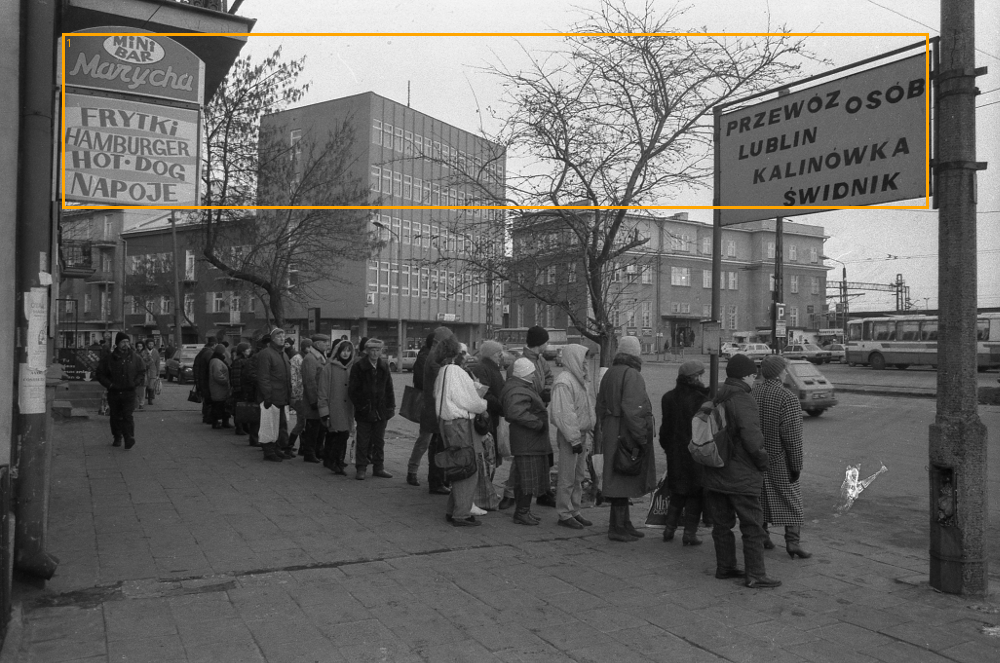

In [6]:
# 4 --- Grupowanie linii w akapity (Vision -> paragraphs) ---
from PIL import ImageDraw, ImageFont
import numpy as np, json

def _box_union(b1, b2):
    return [min(b1[0], b2[0]), min(b1[1], b2[1]), max(b1[2], b2[2]), max(b1[3], b2[3])]

def _line_height(b):
    return max(1, b[3] - b[1])

def _center_y(b):
    return (b[1] + b[3]) / 2.0

def group_lines_into_paragraphs(lines,
                                y_gap_factor=0.9,   # ile wysokości linii może dzielić sąsiadujące wiersze w akapicie
                                x_gap_factor=0.8,   # ile szerokości średniego znaku może dzielić sąsiadujące słowa
                                min_overlap_y=0.15, # minimalne pionowe nakładanie (procent) by uznać „ten sam wiersz”
                                join_hyphen=True):
    if not lines:
        return []

    # Posortuj z grubsza: od góry do dołu, potem od lewej
    L = sorted(lines, key=lambda l: (_center_y(l["bbox"]), l["bbox"][0]))

    # Oszacuj typową wysokość linii
    h_median = np.median([_line_height(l["bbox"]) for l in L])
    y_thresh = max(6, float(h_median) * y_gap_factor)

    # Grupowanie najpierw w „wiersze” (linie o zbliżonej wysokości Y i nakładaniu pionowym)
    rows = []
    for l in L:
        placed = False
        for row in rows:
            # sprawdź czy środek-y blisko któregoś wiersza
            ry = np.mean([_center_y(x["bbox"]) for x in row])
            if abs(_center_y(l["bbox"]) - ry) <= y_thresh:
                # dodatkowo pionowe nakładanie
                a, b = l["bbox"], [min(x["bbox"][1] for x in row), max(x["bbox"][3] for x in row)]
                inter = max(0, min(a[3], b[1]+(b[1]-b[0])) - max(a[1], b[0]))  # przybliżenie
                denom = max(_line_height(a), b[1]-b[0]) or 1
                if (inter/denom) >= min_overlap_y or True:  # łagodnie
                    row.append(l); placed=True; break
        if not placed:
            rows.append([l])

    # Każdy wiersz: sort po x i sklejenie wyrazów gdy przerwa mała
    def merge_row(row):
        row = sorted(row, key=lambda l: l["bbox"][0])
        parts = [row[0]]
        for l in row[1:]:
            prev = parts[-1]
            # szerokość znaku ~ szerokość bbox / max(liczba znaków, 1)
            prev_w = max(1, prev["bbox"][2]-prev["bbox"][0])
            chw = prev_w / max(1, len(prev["text"]))
            x_gap = l["bbox"][0] - prev["bbox"][2]
            if x_gap <= max(4, chw * 6 * x_gap_factor):
                # ten sam „ciąg” tekstu
                joiner = "" if prev["text"].endswith("-") and join_hyphen else " "
                prev["text"] = (prev["text"][:-1] if (prev["text"].endswith("-") and join_hyphen) else prev["text"]) + joiner + l["text"]
                prev["bbox"] = _box_union(prev["bbox"], l["bbox"])
            else:
                parts.append(l)
        # Zwróć złączony tekst wiersza
        txt = " ".join([p["text"] for p in parts]).strip()
        bbox = [parts[0]["bbox"][0], min(p["bbox"][1] for p in parts),
                parts[-1]["bbox"][2], max(p["bbox"][3] for p in parts)]
        return {"text": txt, "bbox": bbox}

    merged_rows = [merge_row(r) for r in rows]

    # Teraz sklejaj w akapity: jeśli odstęp pionowy mniejszy niż ~1.3 wysokości i zaczynają się podobnie po lewej
    paras = []
    for r in sorted(merged_rows, key=lambda l: (_center_y(l["bbox"]), l["bbox"][0])):
        if not paras:
            paras.append([r]); continue
        last = paras[-1][-1]
        dy = r["bbox"][1] - last["bbox"][3]  # odległość między wierszami
        left_similar = abs(r["bbox"][0] - last["bbox"][0]) <= max(10, 0.6*h_median)
        if dy <= 1.3*h_median and left_similar:
            paras[-1].append(r)
        else:
            paras.append([r])

    # Finalny akapit = join tekstów + union bbox
    out = []
    for par in paras:
        txt = " ".join([x["text"] for x in par]).strip()
        xb1 = min(x["bbox"][0] for x in par); yb1 = min(x["bbox"][1] for x in par)
        xb2 = max(x["bbox"][2] for x in par); yb2 = max(x["bbox"][3] for x in par)
        out.append({"text": txt, "bbox":[xb1,yb1,xb2,yb2], "n_lines": len(par)})
    return out

# — uruchom na wynikach z poprzedniej komórki —
paragraphs = group_lines_into_paragraphs(lines,
                                         y_gap_factor=0.9,
                                         x_gap_factor=0.8,
                                         min_overlap_y=0.15,
                                         join_hyphen=True)

# pokaż i zapisz
print(f"🧩 Akapity: {len(paragraphs)} (z {len(lines)} linii)")
for i, p in enumerate(paragraphs[:12], 1):
    print(f"{i:02d}. [{p['n_lines']} l.] {p['text'][:140]}{'…' if len(p['text'])>140 else ''}")

out_par = OUT_DIR / f"{IMG_PATH.stem}_full_grouped.json"
out_par.write_text(json.dumps(paragraphs, ensure_ascii=False, indent=2))
print("Zapisano:", out_par)

# podgląd bbox akapitów
viz = Image.open(IMG_PATH).convert("RGB")
draw = ImageDraw.Draw(viz)
for i, p in enumerate(paragraphs, 1):
    x1,y1,x2,y2 = p["bbox"]
    draw.rectangle([x1,y1,x2,y2], outline="orange", width=3)
    draw.text((x1+4, y1+4), str(i), fill="orange")
display(viz)

### 5) Diagnostyka: kafelkowanie i pomiar czasów (opcjonalne)

In [9]:
import time, io
from PIL import Image
from google.cloud import vision

def diag_vision_timing(img_path, rows=2, cols=3, overlap=0.2, lang=("pl",)):
    client = vision.ImageAnnotatorClient()
    img = Image.open(img_path)
    W, H = img.size
    print(f"Obraz: {W}×{H}px  |  {rows}×{cols} kafelków, overlap={overlap}")

    def tiles():
        tw, th = W / cols, H / rows
        sx, sy = tw * (1 - overlap), th * (1 - overlap)
        for j in range(rows):
            for i in range(cols):
                yield int(i * sx), int(j * sy), int(i * sx + tw), int(j * sy + th)

    times = []
    for i, (x1, y1, x2, y2) in enumerate(tiles(), 1):
        crop = img.crop((x1, y1, x2, y2))
        buf = io.BytesIO()
        crop.save(buf, format="PNG")
        image = vision.Image(content=buf.getvalue())

        t0 = time.time()
        _ = client.text_detection(
            image=image, image_context=vision.ImageContext(language_hints=list(lang))
        )
        dt = time.time() - t0
        times.append(dt)
        print(f"Kafelek {i:02d}: {dt:.2f}s")

    print(f"Średnio: {sum(times)/len(times):.2f}s, łącznie {sum(times):.2f}s")

### 6) Siatka kafelków z numerami (overlay)

Obraz: 1000×663px  |  2×3 kafelków, overlap=0.2


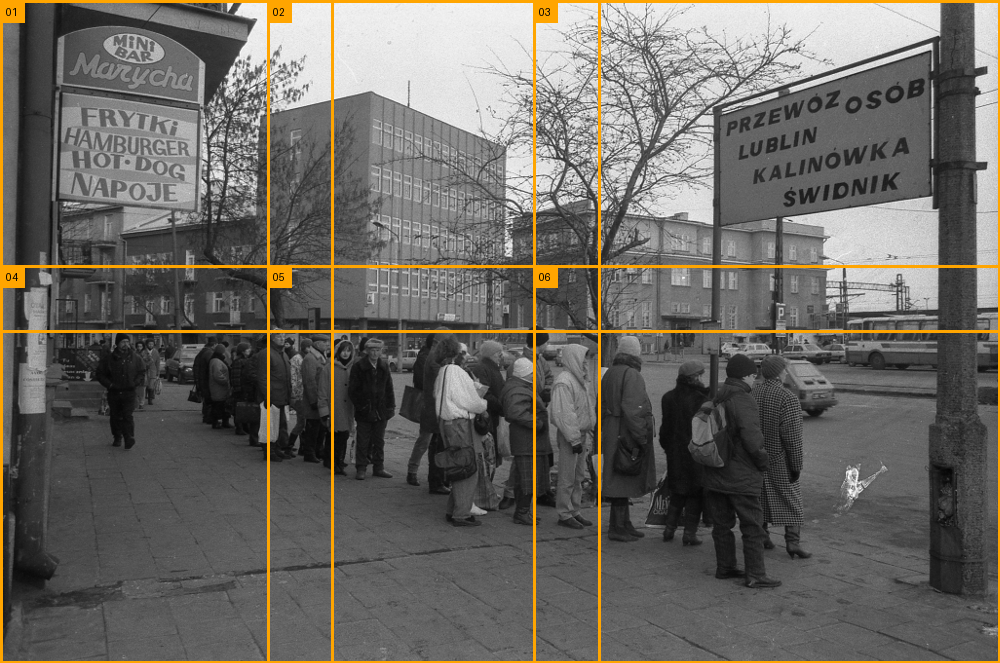

In [11]:
### 6) Siatka kafelków z numerami (overlay)
from PIL import Image, ImageDraw, ImageFont

# parametry siatki
ROWS, COLS = 2, 3
OVERLAP = 0.20   # 0..1 (np. 0.2 to 20% nakładania)

def compute_tiles(w, h, rows=ROWS, cols=COLS, overlap=OVERLAP):
    """Zwraca listę bboxów (x1,y1,x2,y2) dla kafelków z nakładaniem i bez szczelin na krawędziach."""
    tw, th = w / cols, h / rows
    sx, sy = tw * (1 - overlap), th * (1 - overlap)
    tiles = []
    for r in range(rows):
        for c in range(cols):
            x1 = int(round(c * sx))
            y1 = int(round(r * sy))
            # ostatnie kafelki sięgają do krawędzi obrazu
            x2 = int(round(x1 + tw)) if c < cols - 1 else w
            y2 = int(round(y1 + th)) if r < rows - 1 else h
            tiles.append((x1, y1, x2, y2))
    return tiles

# wczytaj obraz i policz siatkę
_img = Image.open(IMG_PATH).convert("RGB")
W, H = _img.size
TILES = compute_tiles(W, H, ROWS, COLS, OVERLAP)

# narysuj overlay z numerami
overlay = _img.copy()
draw = ImageDraw.Draw(overlay)
try:
    font = ImageFont.truetype("DejaVuSans.ttf", size=max(14, W // 60))
except Exception:
    font = ImageFont.load_default()

for i, (x1, y1, x2, y2) in enumerate(TILES, start=1):
    draw.rectangle([x1, y1, x2, y2], outline="orange", width=3)
    label = f"{i:02d}"
    pad = 6
    box_w = int(font.getlength(label)) + 2 * pad
    box_h = int(getattr(font, "size", 14)) + 2 * pad
    draw.rectangle([x1, y1, x1 + box_w, y1 + box_h], fill="orange")
    draw.text((x1 + pad, y1 + pad), label, fill="black", font=font)

print(f"Obraz: {W}×{H}px  |  {ROWS}×{COLS} kafelków, overlap={OVERLAP}")
display(overlay)

### 7) Podgląd kafelka (dropdown + crop)

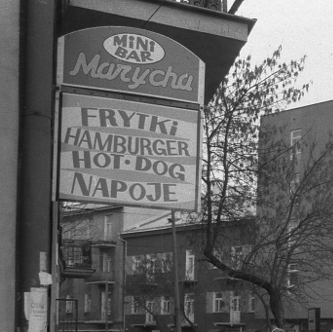

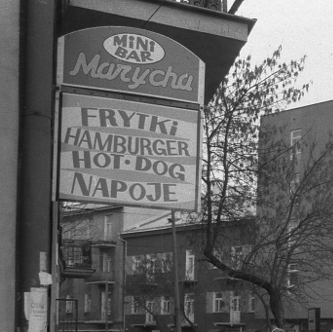

In [ ]:
### 7) Podgląd kafelka (dropdown + crop)
from ipywidgets import Dropdown, Button, HBox, VBox, HTML
from IPython.display import display
from PIL import Image

# upewnij się, że mamy TILES z poprzedniej komórki
assert 'TILES' in globals() and len(TILES)>0, "Najpierw uruchom komórkę 5a."

# dropdown z opisami
def tile_label(idx, box):
    x1,y1,x2,y2 = box
    return f"{idx:02d} — ({x1},{y1})–({x2},{y2}) {x2-x1}×{y2-y1}px"

options = [(tile_label(i, box), i-1) for i, box in enumerate(TILES, start=1)]
dd_tile = Dropdown(options=options, description="Kafelek:", value=0, layout={"width":"520px"})
btn_show = Button(description="Pokaż")
info = HTML()

def show_selected(_=None):
    idx = dd_tile.value
    x1,y1,x2,y2 = TILES[idx]
    crop = Image.open(IMG_PATH).crop((x1,y1,x2,y2))
    info.value = f"Wybrano kafelek <b>{idx+1:02d}</b>: bbox=({x1},{y1})–({x2},{y2}), rozmiar={crop.size[0]}×{crop.size[1]} px"
    display(crop)

btn_show.on_click(show_selected)

display(VBox([HBox([dd_tile, btn_show]), info]))
# pokaz od razu pierwszy wybór
show_selected()

### 8) OCR wszystkich kafelków + scalanie i podgląd


Kafelek 01 (text): 8 linii, 0.50s
    MINI -> [113, 32, 154, 53]
    BAR -> [116, 45, 151, 62]
    Marycha -> [74, 50, 189, 95]
    FRYTKI -> [81, 104, 179, 136]
    HAMBURGER -> [66, 126, 189, 161]
    HOT -> [71, 148, 121, 173]
    DOG -> [134, 155, 183, 180]
    NAPOJE -> [70, 171, 176, 203]

Kafelek 02 (text): 0 linii, 0.52s
  Fallback doc: 0 linii, 0.47s

Kafelek 03 (text): 5 linii, 0.63s
    PRZEWOZ -> [189, 112, 313, 115]
    OSOB -> [308, 88, 395, 98]
    LUBLIN -> [203, 145, 284, 141]
    KALINOWKA -> [217, 167, 376, 153]
    ŚWIDNIK -> [248, 189, 365, 189]

Kafelek 04 (text): 0 linii, 0.46s
  Fallback doc: 0 linii, 0.42s

Kafelek 05 (text): 0 linii, 0.45s
  Fallback doc: 0 linii, 0.39s

Kafelek 06 (text): 0 linii, 0.58s
  Fallback doc: 0 linii, 0.55s

Kafelki: 6  -> linie raw: 13  -> po scaleniu: 13

--- Wynik scalony ---
MINI                            bbox=[113, 32, 154, 53]
BAR                             bbox=[116, 45, 151, 62]
Marycha                         bbox=[74, 5

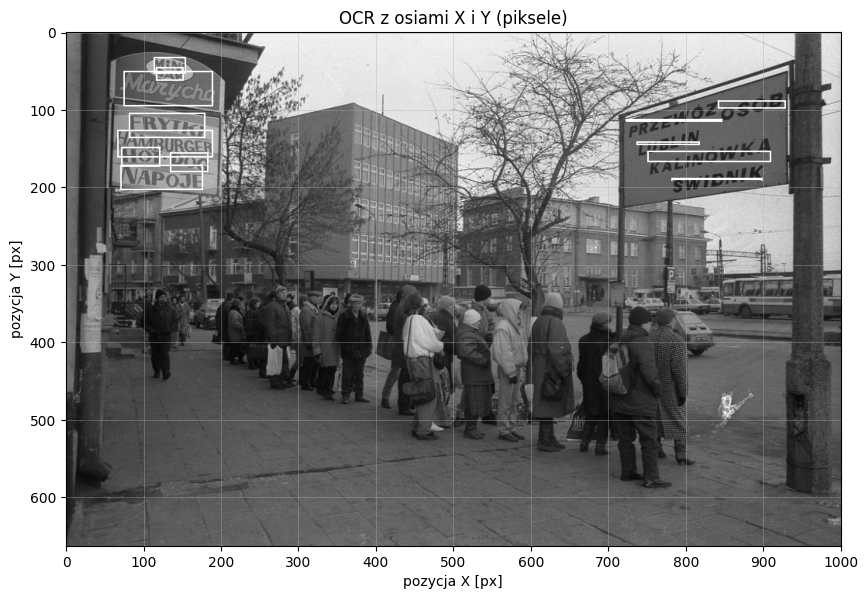

Zapisano: /Users/olga/MetaLogic/outputs/ocr/0077_tiles_merged.json


In [15]:
### 8) OCR wszystkich kafelków + scalanie i podgląd
import io, time, json
from PIL import Image, ImageDraw
from google.cloud import vision
import matplotlib.pyplot as plt
import numpy as np

def ocr_tile(img_full, bbox, mode="text", lang=("pl",)):
    """OCR pojedynczego kafelka obrazu z Google Vision."""
    x1, y1, x2, y2 = map(int, bbox)
    crop = img_full.crop((x1, y1, x2, y2))
    buf = io.BytesIO()
    crop.save(buf, format="PNG")
    image = vision.Image(content=buf.getvalue())

    t0 = time.time()
    if mode == "text":
        response = vision_client.text_detection(
            image=image,
            image_context=vision.ImageContext(language_hints=list(lang))
        )
    else:  # "doc"
        response = vision_client.document_text_detection(
            image=image,
            image_context=vision.ImageContext(language_hints=list(lang))
        )
    dt = time.time() - t0

    # parsowanie odpowiedzi Vision → lista linii
    lines = []
    annotations = response.text_annotations
    if annotations:
        for a in annotations[1:]:  # pomijamy pełny tekst w [0]
            v = a.bounding_poly.vertices
            bx1, by1 = v[0].x, v[0].y
            bx2, by2 = v[2].x, v[2].y
            lines.append({
                "text": a.description,
                "bbox": [bx1, by1, bx2, by2],
            })
    return lines, dt, mode


def iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    if inter == 0:
        return 0.0
    area_a = (ax2 - ax1) * (ay2 - ay1)
    area_b = (bx2 - bx1) * (by2 - by1)
    return inter / (area_a + area_b - inter + 1e-6)


# --- OCR wszystkich kafelków ---
all_lines = []
img_full = Image.open(IMG_PATH).convert("RGB")

for i, bbox in enumerate(TILES, start=1):
    lines, dt, _ = ocr_tile(img_full, bbox, mode="text")
    print(f"\nKafelek {i:02d} (text): {len(lines)} linii, {dt:.2f}s")
    for l in lines:
        print("   ", l["text"], "->", l["bbox"])

    if len(lines) < 3:
        more, dt2, _ = ocr_tile(img_full, bbox, mode="doc")
        lines = more
        print(f"  Fallback doc: {len(lines)} linii, {dt2:.2f}s")
        for l in lines:
            print("   ", l["text"], "->", l["bbox"])

    # translacja bboxów do współrzędnych całego obrazu
    x1, y1, _, _ = bbox
    for l in lines:
        bx1, by1, bx2, by2 = l["bbox"]
        l["bbox"] = [bx1 + x1, by1 + y1, bx2 + x1, by2 + y1]
    all_lines.extend(lines)

# --- Deduplikacja ---
merged = []
for l in all_lines:
    keep = True
    for m in merged:
        if l["text"] == m["text"] and iou(l["bbox"], m["bbox"]) > 0.6:
            keep = False
            break
    if keep:
        merged.append(l)

# --- Normalizacja bboxów, żeby x2>=x1, y2>=y1 ---
for l in merged:
    x1, y1, x2, y2 = l["bbox"]
    x1, x2 = sorted((x1, x2))
    y1, y2 = sorted((y1, y2))
    l["bbox"] = [x1, y1, x2, y2]

print(f"\nKafelki: {len(TILES)}  -> linie raw: {len(all_lines)}  -> po scaleniu: {len(merged)}")

# --- Pełny wypis scalonych linii ---
print("\n--- Wynik scalony ---")
for l in merged:
    print(f"{l['text']:<30}  bbox={l['bbox']}")
print(f"\nŁącznie {len(merged)} odczytanych segmentów tekstu.")

# --- Podgląd graficzny z siatką ---
viz = Image.open(IMG_PATH).convert("RGB")
draw = ImageDraw.Draw(viz)
W, H = viz.size

# narysuj linie co 100 px
for x in range(0, W, 100):
    draw.line([(x, 0), (x, H)], width=1)
for y in range(0, H, 100):
    draw.line([(0, y), (W, y)], width=1)

# --- Podgląd z osiami i współrzędnymi + bboxy ---
viz = Image.open(IMG_PATH).convert("RGB")
draw = ImageDraw.Draw(viz)

for l in merged:
    x1, y1, x2, y2 = l["bbox"]
    draw.rectangle([x1, y1, x2, y2], width=2)

viz_np = np.array(viz)

plt.figure(figsize=(10, 10))
plt.imshow(viz_np)
plt.title("OCR z osiami X i Y (piksele)")
plt.xlabel("pozycja X [px]")
plt.ylabel("pozycja Y [px]")
plt.xticks(np.arange(0, viz.width + 1, 100))
plt.yticks(np.arange(0, viz.height + 1, 100))
plt.grid(linewidth=0.5, alpha=0.5)
plt.show()

# --- Zapis JSON ---
outf = OUT_DIR / f"{IMG_PATH.stem}_tiles_merged.json"
outf.write_text(json.dumps(merged, ensure_ascii=False, indent=2))
print("Zapisano:", outf)

### 9)  Podgląd tekstów po "OCR wszystkich kafelków" ===

In [16]:
# === Podgląd tekstów po "OCR wszystkich kafelków" ===
# Wymaga: `merged` z poprzedniej komórki (lista dictów: {"text","bbox":[x1,y1,x2,y2]})
# Opcjonalnie: funkcja group_lines_into_paragraphs(lines, ...) jeśli chcesz akapity.

from pprint import pprint

def _sort_xy(lines):
    return sorted(lines, key=lambda l: ( (l["bbox"][1]+l["bbox"][3])//2, l["bbox"][0] ))

def _print_lines(lines, limit=None):
    for i, l in enumerate(lines if limit is None else lines[:limit], 1):
        x1,y1,x2,y2 = l["bbox"]
        print(f"[{i:02d}] ({x1},{y1},{x2},{y2})  {l['text']}")

# 1) Wiersze posortowane od góry-lewej
print("— LINIE —")
_lines_sorted = _sort_xy(merged)
_print_lines(_lines_sorted, limit=200)  # zwiększ jeśli chcesz więcej

# 2) Akapity (jeśli masz zdefiniowane group_lines_into_paragraphs)
try:
    print("\n— AKAPITY —")
    paras = group_lines_into_paragraphs(
        [{"text":l["text"], "bbox":l["bbox"]} for l in _lines_sorted],
        y_gap_factor=0.9, x_gap_factor=0.8, min_overlap_y=0.15, join_hyphen=True
    )
    for i,p in enumerate(paras,1):
        print(f"[{i}] {p['text']}")
except NameError:
    print("\n(Akapity pominięte: brak funkcji group_lines_into_paragraphs)")

— LINIE —
[01] (113,32,154,53)  MINI
[02] (116,45,151,62)  BAR
[03] (74,50,189,95)  Marycha
[04] (841,88,928,98)  OSOB
[05] (722,112,846,115)  PRZEWOZ
[06] (81,104,179,136)  FRYTKI
[07] (66,126,189,161)  HAMBURGER
[08] (736,141,817,145)  LUBLIN
[09] (71,148,121,173)  HOT
[10] (750,153,909,167)  KALINOWKA
[11] (134,155,183,180)  DOG
[12] (70,171,176,203)  NAPOJE
[13] (781,189,898,189)  ŚWIDNIK

— AKAPITY —
[1] MINI BAR
[2] Marycha
[3] OSOB
[4] FRYTKI PRZEWOZ
[5] HAMBURGER HOT DOG LUBLIN KALINOWKA NAPOJE ŚWIDNIK


### 6) Eksport CSV (Dublin Core)

In [ ]:
import pandas as pd

# Zbierz unikalne tagi z wszystkich źródeł
tags = sorted(set(label_tags + object_tags + texts + logo_tags))

# Utwórz strukturę CSV zgodną z dLibra
rows = [
    ("", "pl", "en", "universal"),
    ("Title", "Ulica z szyldami", "Street photo with shop signs", ""),
    ("Description", "Widok ulicy z ludźmi i szyldami.", "Street view with people and text signs.", "")
]

# Dodaj wszystkie tagi jako Subject
for t in tags:
    rows.append(("Subject", "", t, ""))

# Dodaj scenę (jeśli istnieje)
if "scene_top" in locals() and scene_top:
    for scene, _ in scene_top:
        rows.append(("Subject", "", scene, ""))

# Zapisz CSV
out_csv = OUT_DIR / "import_dlibra.csv"
pd.DataFrame(rows).to_csv(out_csv, index=False, header=False, encoding="utf-8")

print("csv:", out_csv)